<a href="https://colab.research.google.com/github/bhar-gav/Intent-detection-models---banking-domain/blob/main/Roberta_large_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
print(os.getcwd())
datasets="/content/drive/My Drive/Colab Notebooks/nlp/"
os.chdir(datasets)
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Colab Notebooks/nlp


In [ ]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import re
import joblib

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data Collection:

In [ ]:
train_data = pd.read_csv(os.path.join("dataset/banking_data/train.csv"))
test_data = pd.read_csv(os.path.join("dataset/banking_data/test.csv"))

#save_dir = './save_roberta/'

Data Cleaning:

In [ ]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # punctuation
    text = re.sub(r'\d+', '', text)  # numbers
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])  # stopwords

Data Preprocessing:

In [ ]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [ ]:

print("Sample Input:", train_data[:1])
print('Length of text_input:',len(train_data))

Sample Input:                  text      category
0  still waiting card  card_arrival
Length of text_input: 10003


Lable encoder / intent encoding (Training)

In [ ]:
# Encode the intents and save the label encoder
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['category'])
test_data['label'] = label_encoder.transform(test_data['category'])


# Save the LabelEncoder
#joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.pkl'))

['./save_roberta/label_encoder.pkl']

Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Tokenize the utterances
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(




---
Dataloaders


In [ ]:
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = IntentDataset(train_encodings, train_data['label'].tolist())
test_dataset = IntentDataset(test_encodings, test_data['label'].tolist())

Model

---



In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(label_encoder.classes_))
print(model)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32":

Training arguments

---



In [ ]:
training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=0.00001,  # learning rate for AdamW
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    optim='adamw_torch',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train and save model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

model.save_pretrained('./save_roberta')
tokenizer.save_pretrained('./save_roberta')

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,2.136700,0.908850


ram crash -- recovering checkpoint-1251

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

checkpoint_path = './results_roberta/checkpoint-1251'
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')  # Use the same tokenizer

model.save_pretrained('./save_roberta')
tokenizer.save_pretrained('./save_roberta')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


('./save_roberta/tokenizer_config.json',
 './save_roberta/special_tokens_map.json',
 './save_roberta/vocab.json',
 './save_roberta/merges.txt',
 './save_roberta/added_tokens.json')



---



---
**Load model** (testing)



In [ ]:
model = RobertaForSequenceClassification.from_pretrained('./save_roberta')
tokenizer = RobertaTokenizer.from_pretrained('./save_roberta')
label_encoder = joblib.load('./save_roberta/label_encoder.pkl')

Evaluate

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7812
Precision: 0.8133
Recall: 0.7812
F1 Score: 0.7681


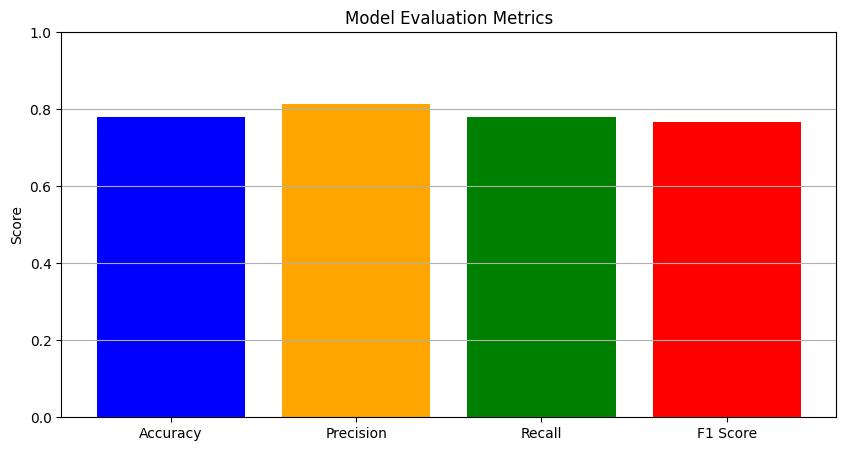

Utterance: 'how do i locate my card?' -> Predicted Intent: 'card_linking'
Utterance: 'check balance in my account' -> Predicted Intent: 'balance_not_updated_after_cheque_or_cash_deposit'
Utterance: 'i need a bank statement.' -> Predicted Intent: 'balance_not_updated_after_cheque_or_cash_deposit'
Utterance: 'i want to deposit some money' -> Predicted Intent: 'balance_not_updated_after_cheque_or_cash_deposit'


In [ ]:

test_data['label'] = label_encoder.transform(test_data['category'])
def predict_utterance(utterance):
    inputs = tokenizer(utterance, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

# test dataset predictions
test_predictions = []
for text in test_data['text']:
    pred = predict_utterance(text)
    test_predictions.append(pred)

# evaluation metrics
accuracy = accuracy_score(test_data['label'], test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], test_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plots
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# examples
example_utterances = [
    "how do i locate my card?",
    "check balance in my account",
    "i need a bank statement.",
    "i want to deposit some money",
]

# predict for examples
predictions = {utterance: label_encoder.inverse_transform([predict_utterance(utterance)])[0] for utterance in example_utterances}

for utterance, intent in predictions.items():
    print(f"Utterance: '{utterance}' -> Predicted Intent: '{intent}'")


interactive predictions

---



---



**IRL TAGGER**

In [ ]:
import os
import re
import joblib
import torch
import pandas as pd
from nltk.corpus import stopwords
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./save_roberta')
tokenizer = RobertaTokenizer.from_pretrained('./save_roberta')
label_encoder = joblib.load('./save_roberta/label_encoder.pkl')

def predict_utterance(utterance):
    inputs = tokenizer(utterance, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():  # No need to track gradients during inference
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

print("Note: Enter 'quit' to break the loop.")
while True:
    query = input('Query: ')
    if query.lower() == 'quit':
        break

    processed_query = preprocess_text(query)
    category = label_encoder.inverse_transform([predict_utterance(processed_query)])

    print('INTENT:', category[0])
    print()


Note: Enter 'quit' to break the loop.
Query: balance
INTENT: ['balance_not_updated_after_bank_transfer']

Query: chech balance
INTENT: ['balance_not_updated_after_cheque_or_cash_deposit']

Query: banck statement
INTENT: ['extra_charge_on_statement']

Query: give me a bank statement
INTENT: ['balance_not_updated_after_cheque_or_cash_deposit']

Query: i need help
INTENT: ['why_verify_identity']

Query: my account is suspended
INTENT: ['terminate_account']

Query: recover my account
INTENT: ['terminate_account']

Query: deposit some money
INTENT: ['balance_not_updated_after_cheque_or_cash_deposit']

Query: transfer money to someone
INTENT: ['balance_not_updated_after_bank_transfer']

Query: quit




---

**End of task : Intent detection using Roberta-large**

---



In [ ]:
import os
import re
import joblib
import torch
import pandas as pd
from nltk.corpus import stopwords
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./save_roberta')
tokenizer = RobertaTokenizer.from_pretrained('./save_roberta')
label_encoder = joblib.load('./save_roberta/label_encoder.pkl')

def predict_utterance(utterance):
    inputs = tokenizer(utterance, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():  # No need to track gradients during inference
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

print("Note: Enter 'quit' to break the loop.")
while True:
    query = input('Query: ')
    if query.lower() == 'quit':
        break

    processed_query = preprocess_text(query)
    category = label_encoder.inverse_transform([predict_utterance(processed_query)])

    print('INTENT:', category[0])
    print()


Note: Enter 'quit' to break the loop.
Query: check balance in my account
INTENT: balance_not_updated_after_cheque_or_cash_deposit

Query: i need a bank statement
INTENT: balance_not_updated_after_cheque_or_cash_deposit

Query: when is my credit card arriving
INTENT: card_arrival

Query: i need my account details
INTENT: why_verify_identity

Query: i am a customer i need to talk to manager
INTENT: Refund_not_showing_up

Query: quit
